7/10 (Sun)

---

# Training Semantic Segmentator

### Objective

- To generate/complete depth image, it is useful to use information about occlusion boundary and normal surface
- However, there are a few dataset of them
- Therefore, I trained semantic segmentator instead of occlusion boundary estimator (becuz image is similar to the boundary)

In [5]:
import os
from pathlib import Path
import json
from datetime import datetime
from PIL import Image
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import JupyterNotebookReporter
from functools import partial

from utils.data import load_kitti_semantics_dataset, show_image
from utils.segnet_basic import SegNetBasic
from utils.segnet import SegNet
from utils.train import Trainer
from utils.early_stop import EarlyStopper

In [6]:
LOAD_DIR = Path("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/dataset/data_semantics")
SAVE_DIR = Path("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/results/segmentation/ray_results")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

### 1. Load data

In [7]:
train_dataset, val_dataset, test_dataset = load_kitti_semantics_dataset(LOAD_DIR)

loading train & validation data: 0it [00:00, ?it/s]

loading test data: 0it [00:00, ?it/s]

In [ ]:
input_example, label_example = train_dataset[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


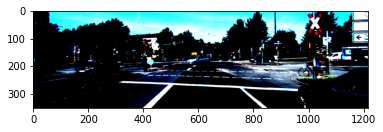

<Figure size 432x288 with 0 Axes>

In [ ]:
ax = show_image(input_example)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


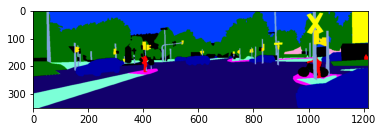

<Figure size 432x288 with 0 Axes>

In [ ]:
ax = show_image(label_example)

### 2. Preparation for training

In [ ]:
class SegNetTrainer(Trainer):
    def train_batch(
        self,
        batch: torch.Tensor, 
        model: nn.Module, 
        optimizer: torch.optim.Optimizer, 
        criterion: nn.Module
    ):
        inputs, labels = batch
        inputs = inputs.to(self.device).float()
        labels = labels.to(self.device).float()

        optimizer.zero_grad()

        preds = model(inputs)

        loss = criterion(preds, labels)
        loss.backward()

        optimizer.step()

        return loss

In [9]:
def evaluate(model, val_dataset, losses, device):
    model.eval()
    model.to(device)

    inputs, labels = val_dataset[:]
    inputs = inputs.to(device).float()
    labels = labels.to(device).float()
    
    preds = model(inputs)

    mse = F.mse_loss(preds, labels)

    ax = plt.subplot()
    ax.plot(
        list(range(len(losses))),
        losses
    )
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    plt.savefig("loss.png")
    plt.clf()

    ax_origin = show_image(inputs[0].to("cpu"), show=False)
    plt.savefig("val_origin.png")
    plt.clf()

    ax_label = show_image(labels[0].to("cpu"), show=False)
    plt.savefig("val_label.png")
    plt.clf()

    ax_pred = show_image(preds[0].to("cpu"), show=False)
    plt.savefig("val_pred.png")
    plt.clf()

    return mse.to("cpu")

In [ ]:
def train_evaluation(config, options):
    save_dir = SAVE_DIR / datetime.now().strftime("%Y%m%d_%H-%M-%S")
    save_dir.mkdir(parents=True, exist_ok=True)
    os.chdir(save_dir)
    
    # model = SegNetBasic(
    #     **config["params"]
    # )

    model = SegNet(
        **config["params"]
    )

    optimizer = Adam(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )

    criterion = nn.MSELoss()

    early_stopper = options["early_stopper"]

    epoch, batch_size = config["epoch"], config["batch_size"]

    trainer = SegNetTrainer(device=options["device"])
    losses = trainer.train(
        model, optimizer, criterion,
        options["train_dataset"], epoch, batch_size,
        early_stopper=early_stopper, verbose=options["verbose"],
        **options["params"]
    )

    mse = evaluate(
        model, options["val_dataset"], losses, options["device"]
    )

    metrics = {
        "MSE": mse
    }

    # with open("dataset.pkl", "wb") as f:
    #     pkl.dump({
    #         "train_dataset": options["train_dataset"],
    #         "val_dataset": options["val_dataset"]
    #     }, f)

    with open("params.json", "w") as f:
        json.dump(config, f)

    if tune.is_session_enabled():
        tune.report(**metrics)
    else:
        for key, val in metrics.items():
            print(f"{key}:\t{val:.03f}")

In [ ]:
def parralel_evaluation(config, options, n_trial=5):
    scheduler = ASHAScheduler(
        metric="MSE",
        mode="max",
        max_t=1000,
        grace_period=5,
        reduction_factor=2
    )

    reporter = JupyterNotebookReporter(
        overwrite=True,
        metric_columns=["MSE"],
        max_progress_rows=20,
        max_report_frequency=5
    )

    ray_result = tune.run(
        partial(train_evaluation, options=options),
        verbose=1,
        resources_per_trial={"cpu": 2, "gpu": 0.5},
        local_dir=str("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/results/segmentation/ray_results"),
        config=config,
        num_samples=n_trial,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    return ray_result

### 3. Experiment

In [ ]:
config = {
    "batch_size": 4,
    "epoch": 300,
    "lr": 0.002,
    "weight_decay": 0.0002,
    "params": {
        "n_channels": 3,
        "n_out": 3,
        "bn_momentum": 0.1,
    }
}

In [ ]:
bn_momentum = [0.1, 0.3, 0.5]
for i in range(3):
    options = {
        "early_stopper": EarlyStopper(patience=5, verbose=False),
        "verbose": False,
        "device": "cuda:0",
        "params": {},
        "train_dataset": train_dataset,
        "val_dataset": val_dataset
    }
    config["bn_momentum"] = bn_momentum[i]

    train_evaluation(config, options)

training:   0%|          | 0/300 [00:00<?, ?it/s]

Early stop


RuntimeError: [enforce fail at CPUAllocator.cpp:71] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 2191523840 bytes. Error code 12 (Cannot allocate memory)

In [8]:
model = SegNet(3, 3, 0.1)
model.load_state_dict(torch.load("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/results/segmentation/ray_results/20220715_20-24-14/checkpoint_model.pt"))

<All keys matched successfully>

In [15]:
y = model(val_dataset.X[0:1].to("cuda:1"))
y

tensor([[[[-0.1834, -0.2719, -0.2915,  ..., -0.4647, -0.4086, -0.1923],
          [-0.1710, -0.3816, -0.2958,  ..., -0.5829, -0.3920, -0.2164],
          [-0.2494, -0.2929, -0.2576,  ..., -0.5379, -0.4303, -0.2397],
          ...,
          [ 0.0274,  0.0280, -0.0092,  ..., -0.1236, -0.0881, -0.0171],
          [-0.0192,  0.0272,  0.0544,  ..., -0.0352,  0.0254, -0.0225],
          [-0.0097,  0.0613,  0.0062,  ...,  0.0517, -0.0200,  0.0627]],

         [[ 0.1514,  0.2232,  0.1535,  ..., -0.0054, -0.0448,  0.0040],
          [ 0.1519,  0.1882,  0.1374,  ..., -0.2315, -0.1112, -0.0493],
          [ 0.2130,  0.2386,  0.2974,  ..., -0.2458, -0.1946, -0.1431],
          ...,
          [ 0.3009,  0.2341,  0.0829,  ..., -0.6291, -0.2795, -0.2125],
          [ 0.1041, -0.0643, -0.1902,  ..., -0.5671, -0.3243, -0.2067],
          [-0.0479, -0.3003, -0.3785,  ..., -0.4062, -0.2361, -0.1255]],

         [[-0.5630, -0.7129, -0.8094,  ...,  0.1370,  0.0606, -0.0389],
          [-0.6712, -0.8804, -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


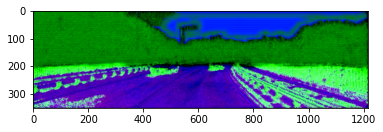

<Figure size 432x288 with 0 Axes>

In [18]:
show_image(y.to("cpu")[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


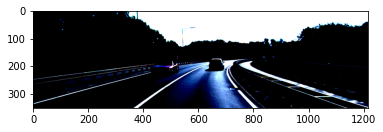

<Figure size 432x288 with 0 Axes>

In [22]:
show_image(val_dataset.X[0:1][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


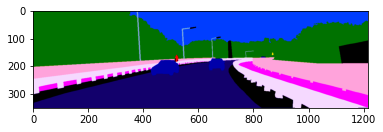

<Figure size 432x288 with 0 Axes>

In [23]:
show_image(val_dataset.Y[0:1][0])